In [42]:
# Import PyTorch Modules 

import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
import os

In [43]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [44]:
# Import Non-PyTorch Modules

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

<hr>


In [45]:
# Url that contains CSV files

train_csv_file = 'data/training_labels.csv'
validation_csv_file = 'data/validation_labels.csv'

In [46]:
# Absolute path for finding the directory contains image datasets

train_data_dir = 'data/training_data_pytorch/'
validation_data_dir = 'data/validation_data_pytorch/'

In [47]:
# Create Dateaset Class

class Dataset(Dataset):
    
    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_name = pd.read_csv(csv_file)
        self.len = self.data_name.shape[0] 
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        img_name = self.data_dir + self.data_name.iloc[idx, 2]
        image = Image.open(img_name)
        y = self.data_name.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, y

In [48]:
# Construct the composed object for transforming the image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

In [49]:
# Create the train dataset and validation dataset

train_dataset = Dataset(transform=composed
                        ,csv_file=train_csv_file
                        ,data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)

<hr>


In [50]:
# Step 1: Load the pre-trained model One

model = models.resnet18(pretrained=True)

c:\Users\vinod\Desktop\Indian currency classification\mynewenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vinod\Desktop\Indian currency classification\mynewenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

model.requires_grad_=False

In [52]:
# Step 3: Re-defined the last layer

model.fc = nn.Linear(in_features=512,out_features=7)

In [53]:
# Print the model

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
# Step 1: Create the loss function

loss = nn.CrossEntropyLoss()

In [55]:
# Step 2: Create the data loader

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=15)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=10)

In [56]:
# Step 3: Use the pre-defined optimizer Adam with learning rate 0.003

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [57]:
# Step 4: Train the model

import matplotlib.pyplot as plt

N_EPOCHS = 7
loss_list = []
accuracy_list =[]
correct=0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(validation_loader):
        outputs = model(images)
        losses = loss(outputs, labels)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    
    mean_val_loss = running_loss / len(validation_loader)
    accuracy = 100. * correct / n_test
    
    loss_list.append(mean_val_loss)
    accuracy_list.append(accuracy)
    
    print(f'Epoch: {epoch+1} Validation Loss: {mean_val_loss:.4f} Accuracy: {accuracy:.4f}')




Epoch: 1 Validation Loss: 4.3682 Accuracy: 0.0000
Epoch: 2 Validation Loss: 2.1586 Accuracy: 14.2857
Epoch: 3 Validation Loss: 2.2691 Accuracy: 28.5714
Epoch: 4 Validation Loss: 2.2425 Accuracy: 31.4286
Epoch: 5 Validation Loss: 2.0501 Accuracy: 47.1429
Epoch: 6 Validation Loss: 1.8992 Accuracy: 72.8571
Epoch: 7 Validation Loss: 1.8607 Accuracy: 95.7143


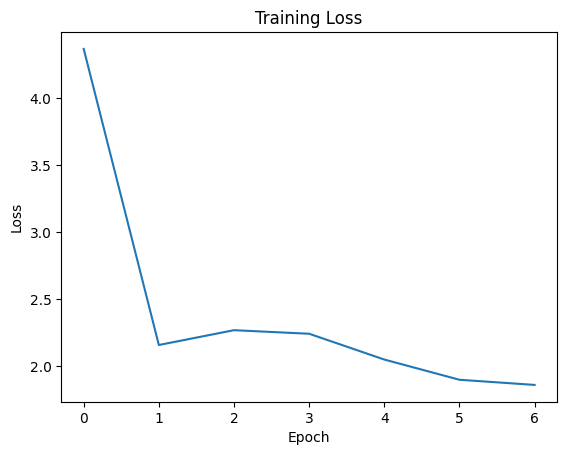

In [58]:
# Step 5: Plot the loss for training dataset
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

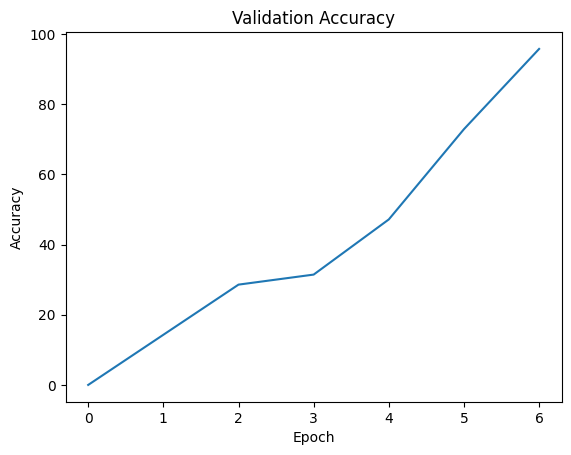

In [59]:
# Step 6: Plot the accuracy for valdiation dataset

plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()


In [60]:
from pathlib import Path
data_path =  Path("data/")
image_path = Path('/Users/vinod/Desktop/resources/data/validation_data_pytorch')

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

\Users\vinod\Desktop\resources\data\validation_data_pytorch directory exists.


In [61]:
import os
def walk_through_dir(dir_path):
      for dirpath, dirnames, filenames in os.walk(dir_path):
       print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [62]:
test_dir = image_path 

In [63]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()  
])

In [64]:
from torchvision import datasets
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Test data:\n{test_data}")



Test data:
Dataset ImageFolder
    Number of datapoints: 72
    Root location: \Users\vinod\Desktop\resources\data\validation_data_pytorch
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [65]:
from torchvision import datasets
# from pathlib import Path

# Define the path to your image data directory
# image_path = Path("C:/Users/vinod/Desktop/resources/data/validation_data_pytorch")

# Load the image data using ImageFolder
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform)
print(f"Test data:\n{test_data}")

Test data:
Dataset ImageFolder
    Number of datapoints: 72
    Root location: \Users\vinod\Desktop\resources\data\validation_data_pytorch
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [66]:
test_data.classes

['0', '1', '2', '3', '4', '5', '6']

In [67]:
class_names = test_data.classes
class_names

['0', '1', '2', '3', '4', '5', '6']

In [68]:
class_dict = test_data.class_to_idx
class_dict

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}

In [69]:
len(test_data)

72

In [70]:
img, label = test_data[0][0], test_data[0][1]
print(f"Image tensor:\n{img}")
# print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")


print(f"Label datatype: {type(label)}")



Image tensor:
tensor([[[0.6902, 0.7255, 0.7255,  ..., 0.7373, 0.7176, 0.7294],
         [0.7294, 0.7255, 0.7529,  ..., 0.7412, 0.7216, 0.7333],
         [0.7098, 0.7333, 0.7529,  ..., 0.7255, 0.7490, 0.7333],
         ...,
         [0.7255, 0.7137, 0.7059,  ..., 0.7255, 0.7451, 0.7255],
         [0.7255, 0.7294, 0.7647,  ..., 0.7412, 0.7412, 0.7216],
         [0.7490, 0.7647, 0.7647,  ..., 0.7412, 0.7255, 0.7255]],

        [[0.5255, 0.5647, 0.5804,  ..., 0.5922, 0.5608, 0.5647],
         [0.5686, 0.5647, 0.6039,  ..., 0.5961, 0.5647, 0.5686],
         [0.5529, 0.5804, 0.6078,  ..., 0.5804, 0.5961, 0.5686],
         ...,
         [0.5765, 0.5843, 0.5686,  ..., 0.5843, 0.6000, 0.5804],
         [0.5529, 0.5765, 0.6039,  ..., 0.5961, 0.5961, 0.5765],
         [0.5647, 0.5922, 0.6078,  ..., 0.5961, 0.5804, 0.5804]],

        [[0.4314, 0.4667, 0.4784,  ..., 0.5098, 0.4745, 0.4745],
         [0.4706, 0.4667, 0.5059,  ..., 0.5176, 0.4784, 0.4784],
         [0.4549, 0.4824, 0.5137,  ..., 0.50

In [71]:
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1,                             shuffle=False) 
test_dataloader

In [72]:
img, label = next(iter(test_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [73]:
test_data.classes, test_data.class_to_idx

(['0', '1', '2', '3', '4', '5', '6'],
 {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6})

In [74]:
target_directory = test_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path))])
print(f"Class names found: {class_names_found}")

Target directory: \Users\vinod\Desktop\resources\data\validation_data_pytorch
Class names found: ['0', '0.jpeg', '1', '1.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '17.jpeg', '18.jpeg', '19.jpeg', '2', '2.jpeg', '20.jpeg', '21.jpeg', '22.jpeg', '23.jpeg', '24.jpeg', '25.jpeg', '26.jpeg', '27.jpeg', '28.jpeg', '29.jpeg', '3', '3.jpeg', '30.jpeg', '31.jpeg', '32.jpeg', '33.jpeg', '34.jpeg', '35.jpeg', '36.jpeg', '37.jpeg', '38.jpeg', '39.jpeg', '4', '4.jpeg', '40.jpeg', '41.jpeg', '42.jpeg', '43.jpeg', '44.jpeg', '45.jpeg', '46.jpeg', '47.jpeg', '48.jpeg', '49.jpeg', '5', '5.jpeg', '50.jpeg', '51.jpeg', '52.jpeg', '53.jpeg', '54.jpeg', '55.jpeg', '56.jpeg', '57.jpeg', '58.jpeg', '59.jpeg', '6', '6.jpeg', '60.jpeg', '61.jpeg', '62.jpeg', '63.jpeg', '64.jpeg', '65.jpeg', '65.jpg', '66.jpeg', '66.jpg', '67.jpeg', '68.jpeg', '69.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


In [75]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [76]:
find_classes(test_dir)

(['0', '1', '2', '3', '4', '5', '6'],
 {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6})

In [77]:
from torch.utils.data import Dataset
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        def load_image(self, index: int) -> Image.Image:
            image_path = self.paths[index]
            return Image.open(image_path) 
        def __len__(self) -> int:
            "Returns the total number of samples."
            return len(self.paths)
        def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
            "Returns one sample of data, data and label (X, y)."
            img = self.load_image(index)
            class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
            class_idx = self.class_to_idx[class_name]
            if self.transform:
                return self.transform(img), class_idx # return data, label (X, y)
            else:
                return img, class_idx 


In [78]:
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [79]:

test_data_custom = ImageFolderCustom(targ_dir=test_dir)
test_data_custom

In [80]:
import torch
import random
import matplotlib.pyplot as plt
from typing import List

look_up = {0: 'predicted:₹10',
           1: 'predicted:₹20',
           2: 'predicted:₹50',
           3: 'predicted:₹100',
           4: 'predicted:₹200',
           5: 'predicted:₹500',
           6: 'predicted:₹2000'}

random.seed(0)
numbers = random.sample(range(70), 5)

def plot_random_image(dataset: torch.utils.data.dataset.Dataset,
                      classes: List[str] = None,
                      numbers: int = 5,
                      seed: int = None
                     ):
    # Adjust display if numbers is too high
    if numbers > 5:
        numbers = 5
            
    # Set random seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=numbers)

    # Setup plot
    fig, axes = plt.subplots(nrows=1, ncols=numbers, figsize=(12, 6))

    # Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        
        # Plot adjusted samples
        axes[i].imshow(targ_image_adjust)
        axes[i].axis("off")
        classified_title = 'Classified'
        if classes:
            predicted_label = look_up[targ_label]
            
            axes[i].set_title(predicted_label+ '\n' + classified_title, y=1.05, fontsize=10, ha='center')
        else:
            axes[i].set_title(predicted_label+ '\n' 'UnClassified', y=1.05, fontsize=10, ha='center')

    plt.tight_layout()
    plt.show()

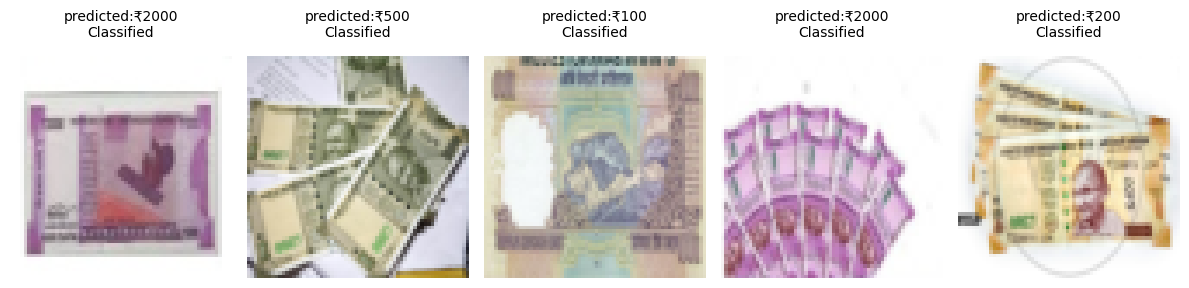

In [81]:


   
plot_random_image(test_data,
                  numbers=5,
                  classes=class_names,
                  seed=None
            )


In [82]:
# Save the model

torch.save(model, "resnet18_pytorch.pt")
